<a href="https://colab.research.google.com/github/zihvvan/DeepLearning/blob/main/zihvvan/ch09_DL_06_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%EC%9E%8E%EC%82%AC%EA%B7%80_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스라인 모델

## 환경 설정

In [1]:
import torch
import random
import numpy as np
import os

# 시드값
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (cpu)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (gpu)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 gpu)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False # cudnn 사용 해제

In [2]:
# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

In [3]:
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7
!kaggle competitions download -c plant-pathology-2020-fgvc7

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 779M/779M [00:39<00:00, 23.1MB/s]
100% 779M/779M [00:39<00:00, 20.9MB/s]


In [4]:
!unzip plant-pathology-2020-fgvc7

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [5]:
import pandas as pd

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')

# 데이터 경로 (Kaggle 대응)
data_path = './'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### 훈련 데이터, 검증 데이터 분리

> Kaggle Competition 데이터셋에서 훈련셋과 검증셋을 어떻게 나눠야해?
* https://sharegpt.com/c/yW0rrgt

In [6]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [8]:
train.columns.tolist()[1:]

['healthy', 'multiple_diseases', 'rust', 'scab']

In [9]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,
                                test_size=0.1, # 10%를 검증셋으로 사용
                                stratify=train[train.columns.tolist()[1:]], # 특정한 열을 선택
                                # 훈련셋/검증셋을 라벨 비중에 따라서 배분
                                random_state=50)

> 사이킷런에서 train_test_split 메소드를 사용할 때, 관측값과 예측값을 제공했을 때와 train 데이터만 제공했을 때의 결과 차이를 설명해주고, train 데이터만 제공했을 때 어떻게 계층화(stratify)하는지에 대해서 설명해줘
* https://sharegpt.com/c/K2IagQP

In [10]:
print(f'훈련 데이터 개수 : {len(train)}')
print(f'검증 데이터 개수 : {len(valid)}')

훈련 데이터 개수 : 1638
검증 데이터 개수 : 183


In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def show_stratified(df):
    healthy = df.loc[df['healthy']==1]
    multiple_diseases = df.loc[df['multiple_diseases']==1]
    rust = df.loc[df['rust']==1]
    scab = df.loc[df['scab']==1]

    mpl.rc('font', size=15)
    plt.figure(figsize=(7, 7))

    # label = train.columns.tolist()[1:]
    label = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # 타깃값 분포 파이 그래프
    plt.pie(
        [len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels = label,
        autopct = '%.1f%%' # 소수점 1째자리까지
    )
    plt.show()

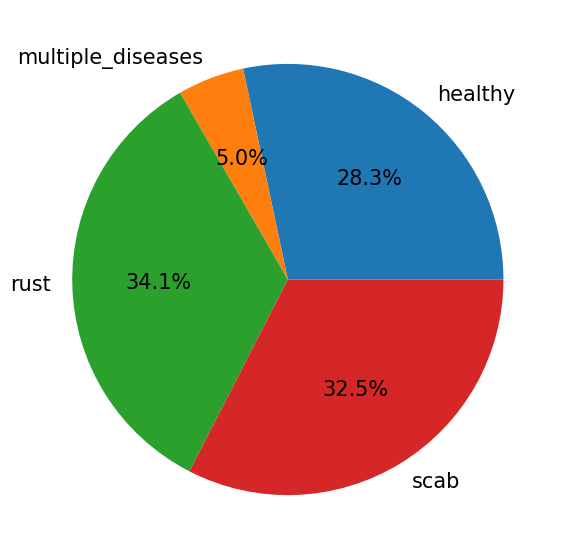

In [12]:
show_stratified(train)

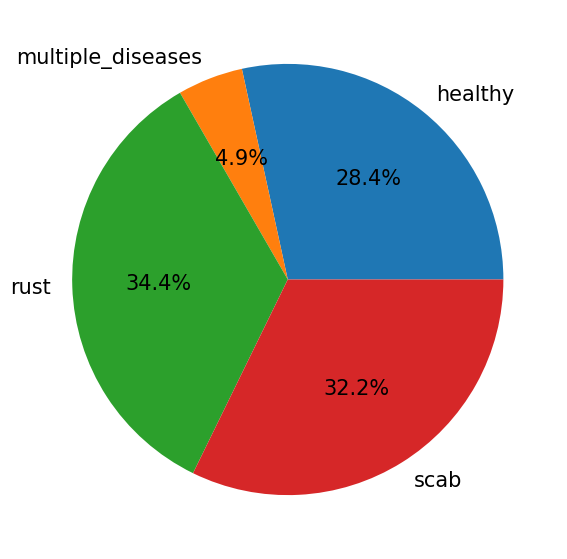

In [13]:
show_stratified(valid)

### 데이터셋 클래스

> pytorch에서 외부 이미지로, 이미지 데이터셋을 만드는 방법을 예시코드와 함께 알려줘
* https://sharegpt.com/c/4BQVkza

> 파이썬에서 `__init__, __str__, __len__, __get_item__` 매직메소드들의 특징과 기능에 대해서 예시코드와 함께 설명해줘
* https://sharegpt.com/c/z10Hcxz

In [14]:
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    # 초기화 메소드(생성자)
    def __init__(self,
                 df,
                 img_dir = './',
                 transform = None,
                 is_test=False, # **
                 # 데이터셋을 훈련용 또는 검증용 : False
                 # -> 라벨을 같이 반환
                 # 테스트용으로 만들 거면 : True
                 # -> 이미지만 반환
                 ):
        super().__init__()
        
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test # **
    
    # 데이터셋 크기 반환 메소드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메소드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # 이미지 ID (이미지 파일 이름)
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일의 전체 경로
        # ** '.jpg'가 원본에 없기 때문에 확장자 추가
        image = cv2.imread(img_path) # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 (cv2 -> plt)
        # 기본 변환기 쓸 때
        # if self.transform is not None:
        #     image = self.transform(image) # 변환기(transform)가 있다면 이미지 변환
        # ** albumentations 변환기
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 (이미지랑) 타깃값도 반환
        if self.is_test:
            return image # 테스트용일 때 이미지만.
        # 타깃값 4개 중 가장 큰 값의 인덱스 -> 1, 0, 0, 0 => 0번째
        label = np.argmax(self.df.iloc[idx, 1:5]) # 원핫인코딩 -> 라벨인코딩 (0~3)
        return image, label # 훈련/검증용일 때 이미지 & 라벨(타깃값)을 모두 리턴

> albumentations과 기존 pytorch에서의 transform 간의 차이점이 뭐야?
* https://shareg.pt/IxX7JfX

> np.argmax를 통해서 더미변수(원핫인코딩)들을 라벨인코딩으로 변경하는 방법의 원리와 예시 코드를 알려줘
* https://shareg.pt/viTjE6w

### 이미지 변환기 정의

In [15]:
# https://albumentations.ai/docs/
# https://gaussian37.github.io/dl-pytorch-albumentation/
import albumentations as A
from albumentations.pytorch import ToTensorV2

> Vertical과 Horizontal에 대한 개념을 Pytorch에서의 flip 기준으로 설명해줘
* https://sharegpt.com/c/faDbCwW

In [16]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절 (+- 랜덤으로 밝기 비율 조정)
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화 (튀어나오게), 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3), # A.OneOf -> 셋 중에 하나만.
    A.PiecewiseAffine(p=0.3), # 어파인 변환 -> 이동, 확대/축소, 회전 => 이미지 모양을 전체적으로 바꾸는 변환기
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

In [17]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

### 데이터셋 생성

In [18]:
# img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'
img_dir = 'images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [19]:
# 멀티 프로세싱을 위한 시드 생성
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

### 데이터로더 생성

In [20]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2) # 빠른 학습을 위한 멀티 프로세싱 적용
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

* (이전까지) 계층(레이어)별 구성 -> 스스로 만들었음
* (이번에는) 사전 훈련된 모델을 전이 학습시키는 것

* **사전 훈련 모델** : 이미 한 분야에서 훈련을 마친 모델
* **전이 학습** : 사전 훈련 모델을 유사한 다른 영역에서 재훈련시키는 기법

**파이토치에서 사전 훈련 모델을 이용하는 방법**
1. torchvision.models 모듈 이용
* https://pytorch.org/vision/stable/models.html
* 제공하는 모델이 많지 않음
* 기본적으로 설치되어 있기 때문에 사용하기 간단
2. pretrainedmodels 모듈 이용
* https://github.com/Cadene/pretrained-models.pytorch
* 테슬라에서 자율주행 연구하는 연구자
3. 직접 구현한 모듈 이용
* 1, 2에는 없는 모델을 사용하고 싶다면? 찾아야 함
* 구글 -> '{원하는 사전 훈련 모델} + github pytorch'

> torchvision.models로 이미지 분류기 신경망을 전이 학습하는 방법을 예시코드와 함께 설명해줘
* https://shareg.pt/MpUcKpX

> pretrainedmodels 모듈로 이미지 분류기 신경망을 전이 학습하는 방법을 예시코드와 함께 설명해줘
* https://sharegpt.com/c/VvHVLTg

> 최신 이미지 분류 모델이 사전학습된 레포지토리를, 전이학습할 수 있도록 설치 방법과 사용방법을 pytorch 기준으로 상세하기 주석과 함께 예제코드로 보여줘. (torchvision에 이미 포함되었거나, pretrainedmodels에 포함된 경우는 제외하고).
* https://sharegpt.com/c/ty3WvXp

> 최신 이미지 분류 모델이 사전학습된 모델을 전이학습할 수 있도록 설치 방법과 사용방법을 pytorch 기준으로 상세하기 주석과 함께 예제코드로 보여줘. 라이브러리 외에도 직접 레포지토리를 통해 설치하는 방법을 포함해서 (torchvision에 이미 포함되었거나, pretrainedmodels에 포함된 경우는 제외하고).
* https://sharegpt.com/c/CQx9eKV

## EfficientNet 모델 생성
* 2019년 5월, CNN

In [21]:
!pip show efficientnet-pytorch
!pip install efficientnet-pytorch==0.7.1 -q
# https://github.com/lukemelas/EfficientNet-PyTorch

  Preparing metadata (setup.py) ... done


In [22]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [23]:
import torch.nn as nn

In [24]:
# 출력값 직접 설정
model = EfficientNet.from_pretrained('efficientnet-b7')

# 전결합 계층 -> 마지막 분류할 때 몇개로 분류할지
model._fc = nn.Sequential( # EfficientNet의 원본이 학습했던 전결합계층의 I/O features
    nn.Linear(model._fc.in_features, model._fc.out_features), # 2560 -> 1000
    nn.ReLU(), # 활성화 함수
    nn.Dropout(p=0.5), # 50% 드롭아웃
    nn.Linear(model._fc.out_features, 4) # 1000 -> 4
 )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:09<00:00, 29.6MB/s]


Loaded pretrained weights for efficientnet-b7


In [25]:
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # 4가지 분류
# num_classes : 출력값의 개수
# 가중치, 특징맵 만드는 레이어들의 정보 가져와서 -> 우리 사정에 맞게 튜닝

model = model.to(device) # 장비 할당

Loaded pretrained weights for efficientnet-b7


## 모델 훈련

In [26]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss() # 다중분류

In [27]:
# 옵티마이저 : Adam -> AdamW : Adam + 가중치 감쇠 추가로 적용
# 가중치 감쇠 weight decay : 가중치를 작게 조절하는 규제 기법으로, 과적합(과대적합)을 억제해줌
# https://aimaster.tistory.com/76
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [28]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [29]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            # labels -> label = np.argmax(self.df.iloc[idx, 1:5]) # 원핫인코딩 -> 라벨인코딩 (0~3)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            '''
            tensor([[0.25, 0.25, 0.25, 0.25]])
            '''

            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].cpu().numpy() # 라벨인코딩 -> 원핫인코딩
            '''
            tensor([[1., 0., 0., 0.],  <- 라벨 0
                    [0., 1., 0., 0.],  <- 라벨 1
                    [0., 0., 1., 0.],  <- 라벨 2
                    [0., 0., 0., 1.]]) <- 라벨 3
            '''
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/5] - 훈련 데이터 손실값 : 0.7109
에폭 [1/5] - 검증 데이터 손실값 : 0.2487 / 검증 데이터 ROC AUC : 0.9561


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/5] - 훈련 데이터 손실값 : 0.3493
에폭 [2/5] - 검증 데이터 손실값 : 0.1873 / 검증 데이터 ROC AUC : 0.9676


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/5] - 훈련 데이터 손실값 : 0.2619
에폭 [3/5] - 검증 데이터 손실값 : 0.1624 / 검증 데이터 ROC AUC : 0.9708


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/5] - 훈련 데이터 손실값 : 0.1753
에폭 [4/5] - 검증 데이터 손실값 : 0.3176 / 검증 데이터 ROC AUC : 0.9803


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/5] - 훈련 데이터 손실값 : 0.1429
에폭 [5/5] - 검증 데이터 손실값 : 0.1507 / 검증 데이터 ROC AUC : 0.9909


In [30]:
!ls drive/MyDrive/'Colab Notebooks'

ls: cannot access 'drive/MyDrive/Colab Notebooks': No such file or directory


In [31]:
!pwd

/content


In [39]:
# 구글 드라이브 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/plant_model1.pt")

RuntimeError: ignored

## 예측 및 결과 제출

In [33]:
# 테스트용 데이터셋, 데이터 로더 생성
dataset_test = ImageDataset(test, img_dir=img_dir,
                            transform=transform_test, is_test=True)
loader_test = DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False,
        worker_init_fn=seed_worker, generator=g, num_workers=2 # 병렬 프로세싱 위한 코드
)

In [34]:
# 예측
model.eval() # 평가 모드

preds = np.zeros((len(test), 4)) # 테스트 데이터셋만큼의 길이를 가지는 4열짜리 행렬 (0을 가득찬)
# preds -> 예측값 저장용 배열

with torch.no_grad(): # 테스트용이므로 기울기 계산 X
    for i, images in enumerate(loader_test): # 테스트용 데이터 로더의 각각 인덱스와 값을 받음
        images = images.to(device)
        outputs = model(images) # 모델을 거친 예측 결과
        # 타깃을 예측한 확률
        print(outputs.cpu())
        print(torch.softmax(outputs.cpu(), dim=1))
        print(torch.softmax(outputs.cpu(), dim=1).squeeze())
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        # outputs -> 신경망의 출력값이 배치 크기만큼 존재
        # -> 소프트맥스 함수 -> 확률값 (0~1) -> preds_part
        preds[i*batch_size:(i+1)*batch_size] += preds_part
        # preds 배열에, 배치 사이즈만큼 계산된 값을, 인덱스에 맞게 집어넣어줌

preds

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [9.8527e-07, 5.0133e-03, 9.9468e-01, 3.0536e-04]])
tensor([[9.2635e-03, 4.2056e-02, 9.4713e-01, 1.5540e-03],
        [3.5863e-04, 2.6336e-03, 2.7540e-03, 9.9425e-01],
        [1.1782e-03, 4.8680e-02, 9.4923e-01, 9.1399e-04],
        [9.8527e-07, 5.0133e-03, 9.9468e-01, 3.0536e-04]])
tensor([[-1.3559, -0.2549, -2.2404,  3.6679],
        [ 5.3505, -2.0447,  0.7504, -3.8913],
        [-0.4327, -1.9098, -3.4614,  5.1318],
        [-2.7977, -0.7029,  7.0144, -4.1943]])
tensor([[6.3937e-03, 1.9227e-02, 2.6401e-03, 9.7174e-01],
        [9.8935e-01, 6.0768e-04, 9.9433e-03, 9.5874e-05],
        [3.8128e-03, 8.7047e-04, 1.8447e-04, 9.9513e-01],
        [5.4756e-05, 4.4482e-04, 9.9949e-01, 1.3549e-05]])
tensor([[6.3937e-03, 1.9227e-02, 2.6401e-03, 9.7174e-01],
        [9.8935e-01, 6.0768e-04, 9.9433e-03, 9.5874e-05],
        [3.8128e-03, 8.7047e-04, 1.8447e-04, 9.9513e-01],
        [5.4756e-05, 4.4482e-04, 9.9949e-01, 1.3549e-05]])
tensor([[ 6.9977, -2.

array([[8.95669567e-04, 4.37840726e-03, 9.93375480e-01, 1.35050924e-03],
       [3.79921266e-06, 1.69118692e-03, 9.98037398e-01, 2.67569703e-04],
       [5.74998558e-03, 2.51264614e-03, 1.79758092e-04, 9.91557598e-01],
       ...,
       [1.71473639e-05, 9.33035451e-04, 9.99044955e-01, 4.92990921e-06],
       [9.97322023e-01, 1.24469574e-04, 1.53745950e-05, 2.53815157e-03],
       [1.99730319e-04, 4.24660183e-03, 1.31475928e-04, 9.95422184e-01]])

In [35]:
# 이미지 ID를 제외한 컬럼들 조회
submission[submission.columns[1:]]
# 예측값을 해당 id에 맞게 집어넣어주는 코드
submission[submission.columns[1:]] = preds

In [36]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000896,0.004378,0.993375,0.001351
1,Test_1,0.000004,0.001691,0.998037,0.000268
2,Test_2,0.005750,0.002513,0.000180,0.991558
3,Test_3,0.999953,0.000003,0.000006,0.000039
4,Test_4,0.000006,0.000298,0.999654,0.000043


In [37]:
submission.to_csv('submission.csv', index=False)

In [38]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>